# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene1-LSTM[SmallWindow]'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 120

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18408, 19052)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([48, 6])

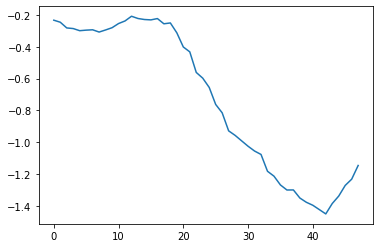

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [16]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.571507
 - Pitch        :  12.092992
 - Roll         :   3.138396
 - RMS          :   9.086689
 - 99% Tile     :  44.509875
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.202319
 - Pitch        :   9.203590
 - Roll         :   3.104402
 - RMS          :   7.724983
 - 99% Tile     :  41.281643
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.983026
 - Pitch        :   8.183115
 - Roll         :   3.092324
 - RMS          :   7.239258
 - 99% Tile     :  38.752107
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.546768
 - Pitch        :   7.264118
 - Roll         :   2.997633
 - RMS          :   5.905178
 - 99% Tile     :  35.049902
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.070459
 - Pitch        :   5.664145
 - Roll         :   2.969563
 - RMS          :   4.712055
 - 99% Tile     :  31.923644
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.117220
 - Pitch        :   4.206060
 - Roll         :   2.905795
 - RMS          :   3.789727
 - 99% Tile     :  29.470524
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.620724
 - Pitch        :   3.549019
 - Roll         :   2.824701
 - RMS          :   3.350827
 - 99% Tile     :  26.959865
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.996929
 - Pitch        :   3.165577
 - Roll         :   2.869638
 - RMS          :   3.013154
 - 99% Tile     :  24.765282
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.582774
 - Pitch        :   2.810243
 - Roll         :   2.873699
 - RMS          :   2.758401
 - 99% Tile     :  22.590728
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.384171
 - Pitch        :   2.562814
 - Roll         :   2.894242
 - RMS          :   2.622272
 - 99% Tile     :  20.769332
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.218490
 - Pitch        :   2.337260
 - Roll         :   2.888963
 - RMS          :   2.498706
 - 99% Tile     :  19.553734
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.201047
 - Pitch        :   2.284651
 - Roll         :   2.941607
 - RMS          :   2.497818
 - 99% Tile     :  18.654150
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.885404
 - Pitch        :   1.829314
 - Roll         :   2.894241
 - RMS          :   2.256677
 - 99% Tile     :  17.907892
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.823134
 - Pitch        :   1.774539
 - Roll         :   2.900360
 - RMS          :   2.227472
 - 99% Tile     :  17.544401
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.905254
 - Pitch        :   1.754606
 - Roll         :   2.832789
 - RMS          :   2.216102
 - 99% Tile     :  16.737105
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.687441
 - Pitch        :   1.575849
 - Roll         :   2.866152
 - RMS          :   2.124899
 - 99% Tile     :  16.694682
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.931689
 - Pitch        :   1.572987
 - Roll         :   2.664629
 - RMS          :   2.106020
 - 99% Tile     :  16.437999
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.508637
 - Pitch        :   1.607288
 - Roll         :   2.125131
 - RMS          :   1.767818
 - 99% Tile     :  15.364065
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.395721
 - Pitch        :   1.467399
 - Roll         :   1.879445
 - RMS          :   1.595161
 - 99% Tile     :  14.955028
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.833164
 - Pitch        :   1.366439
 - Roll         :   1.775783
 - RMS          :   1.671431
 - 99% Tile     :  13.974290
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.973908
 - Pitch        :   1.339520
 - Roll         :   1.555115
 - RMS          :   1.644081
 - 99% Tile     :  13.249593
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.469088
 - Pitch        :   1.320459
 - Roll         :   1.447588
 - RMS          :   1.413900
 - 99% Tile     :  12.843175
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.619629
 - Pitch        :   1.279366
 - Roll         :   1.464162
 - RMS          :   1.461021
 - 99% Tile     :  12.382511
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.701217
 - Pitch        :   1.181407
 - Roll         :   1.355247
 - RMS          :   1.429051
 - 99% Tile     :  12.201609
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.456186
 - Pitch        :   1.500832
 - Roll         :   1.390859
 - RMS          :   1.449996
 - 99% Tile     :  11.988574
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.479304
 - Pitch        :   1.138950
 - Roll         :   1.301848
 - RMS          :   1.314072
 - 99% Tile     :  11.664697
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.362194
 - Pitch        :   1.346412
 - Roll         :   1.290118
 - RMS          :   1.333267
 - 99% Tile     :  11.687657
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.358869
 - Pitch        :   1.126315
 - Roll         :   1.317456
 - RMS          :   1.271587
 - 99% Tile     :  11.353785
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.391900
 - Pitch        :   1.198713
 - Roll         :   1.287723
 - RMS          :   1.295187
 - 99% Tile     :  11.244501
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.533595
 - Pitch        :   1.129420
 - Roll         :   1.186980
 - RMS          :   1.295688
 - 99% Tile     :  11.054941
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.328309
 - Pitch        :   1.073693
 - Roll         :   1.144163
 - RMS          :   1.186919
 - 99% Tile     :  10.943967
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.225228
 - Pitch        :   1.027206
 - Roll         :   1.188079
 - RMS          :   1.150053
 - 99% Tile     :  11.008512
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.238002
 - Pitch        :   1.181033
 - Roll         :   1.159286
 - RMS          :   1.193235
 - 99% Tile     :  10.689828
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.401861
 - Pitch        :   1.129628
 - Roll         :   1.119911
 - RMS          :   1.224129
 - 99% Tile     :  11.165487
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.366588
 - Pitch        :   1.173364
 - Roll         :   1.054396
 - RMS          :   1.205003
 - 99% Tile     :  10.780476
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.205029
 - Pitch        :   1.088046
 - Roll         :   1.234678
 - RMS          :   1.177620
 - 99% Tile     :  10.736970
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.262581
 - Pitch        :   1.062882
 - Roll         :   1.060122
 - RMS          :   1.132503
 - 99% Tile     :  10.641843
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.421234
 - Pitch        :   1.173129
 - Roll         :   1.130835
 - RMS          :   1.248322
 - 99% Tile     :  10.692745
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.283871
 - Pitch        :   1.213818
 - Roll         :   1.016713
 - RMS          :   1.176915
 - 99% Tile     :  10.799874
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.210492
 - Pitch        :   1.053604
 - Roll         :   1.032627
 - RMS          :   1.101770
 - 99% Tile     :  10.518891
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.135058
 - Pitch        :   0.993964
 - Roll         :   1.018953
 - RMS          :   1.051124
 - 99% Tile     :  10.569778
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.407872
 - Pitch        :   1.030830
 - Roll         :   1.019766
 - RMS          :   1.166853
 - 99% Tile     :  11.970945
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.282971
 - Pitch        :   1.029117
 - Roll         :   0.989209
 - RMS          :   1.108096
 - 99% Tile     :  11.645307
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.306309
 - Pitch        :   1.023401
 - Roll         :   0.988988
 - RMS          :   1.115331
 - 99% Tile     :  10.981403
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.441380
 - Pitch        :   0.945646
 - Roll         :   1.011961
 - RMS          :   1.154107
 - 99% Tile     :  12.059302
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.308353
 - Pitch        :   1.043332
 - Roll         :   0.953215
 - RMS          :   1.111898
 - 99% Tile     :  11.620148
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.494782
 - Pitch        :   1.030247
 - Roll         :   0.983086
 - RMS          :   1.191951
 - 99% Tile     :  12.005465
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.296960
 - Pitch        :   1.032347
 - Roll         :   0.927795
 - RMS          :   1.096760
 - 99% Tile     :  12.046807
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.274436
 - Pitch        :   0.977600
 - Roll         :   0.979955
 - RMS          :   1.086309
 - 99% Tile     :  12.217588
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.211103
 - Pitch        :   0.959067
 - Roll         :   0.928916
 - RMS          :   1.040747
 - 99% Tile     :  12.143151
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.133062
 - Pitch        :   0.937280
 - Roll         :   0.946951
 - RMS          :   1.009792
 - 99% Tile     :  11.590515
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.238915
 - Pitch        :   0.965866
 - Roll         :   0.933330
 - RMS          :   1.054974
 - 99% Tile     :  11.890823
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.168531
 - Pitch        :   0.933363
 - Roll         :   0.918609
 - RMS          :   1.013324
 - 99% Tile     :  11.885522
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.185774
 - Pitch        :   0.954113
 - Roll         :   0.943263
 - RMS          :   1.033785
 - 99% Tile     :  11.806446
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.296986
 - Pitch        :   0.939521
 - Roll         :   0.943768
 - RMS          :   1.073246
 - 99% Tile     :  12.268721
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.281587
 - Pitch        :   0.988610
 - Roll         :   0.913310
 - RMS          :   1.072994
 - 99% Tile     :  11.979356
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.250067
 - Pitch        :   1.086574
 - Roll         :   0.946030
 - RMS          :   1.101254
 - 99% Tile     :  12.073525
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.231363
 - Pitch        :   0.928440
 - Roll         :   0.925355
 - RMS          :   1.038354
 - 99% Tile     :  11.708617
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.167101
 - Pitch        :   0.965692
 - Roll         :   0.924524
 - RMS          :   1.024602
 - 99% Tile     :  11.835995
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   1.173541
 - Pitch        :   0.939966
 - Roll         :   0.930896
 - RMS          :   1.020997
 - 99% Tile     :  11.786180
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   1.209384
 - Pitch        :   0.921080
 - Roll         :   0.928963
 - RMS          :   1.028587
 - 99% Tile     :  11.981072
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0061.npy


[0062/0100] Validation: 100%|██████████████████████| 75/75 [00:02<00:00, 27.67it/s, val_loss 5.9929]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   1.219499
 - Pitch        :   0.918761
 - Roll         :   0.920688
 - RMS          :   1.029396
 - 99% Tile     :  11.939128
Save output signals into checkpoint/Scene1-LSTM[SmallWindow]/sample/0062.npy
